In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gnn4itk_cf as gnn
from gnn4itk_cf.stages.track_building.utils import evaluate_tracking, get_statistics, build_pred_bgraph, build_truth_bgraph, match_bgraphs, PartialData
from gnn4itk_cf.stages.graph_construction.models.utils import graph_intersection
from torch_geometric.utils import to_scipy_sparse_matrix, from_scipy_sparse_matrix
from torch_scatter import scatter_add, scatter_mean
from gnn4itk_cf.utils.plotting_utils import get_ratio
from gnn4itk_cf.utils.ml_utils import make_mlp
import yaml
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint
from torch_geometric.data import Data
from scipy.sparse.csgraph import connected_components, min_weight_full_bipartite_matching
from scipy.sparse import coo_matrix, csr_matrix
from typing import Dict, Tuple, Optional, Sequence, Union
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from atlasify import atlasify
GRAPHS_DIR = "/global/cfs/cdirs/m2616/pmtuan/inferred_data/igcn_14999421_epoch66_redo/testset"
TRACKS_DIR = "/global/cfs/cdirs/m2616/pmtuan/inferred_data/igcn_14999421_epoch66_redo_track_candidates_0.5/testset"

In [3]:
paths = []
for path in os.listdir(TRACKS_DIR):
    paths.append(os.path.join(TRACKS_DIR, path))
event = torch.load(paths[0])
tracks = torch.stack([torch.arange(event.labels.shape[0])[event.labels >= 0], event.labels[event.labels >= 0]])

## High Level Statistics

In [9]:
# def select_connected(event, matching_df, track_id):
graph = event.labels[event.edge_index[:, event.scores > 0.01]]
graph = graph[:, (graph != -1).all(0) & (graph[0] != graph[1])]
track_ids = graph[:, (graph == 27973).any(0)].unique()
track_ids

tensor([], dtype=torch.int64)

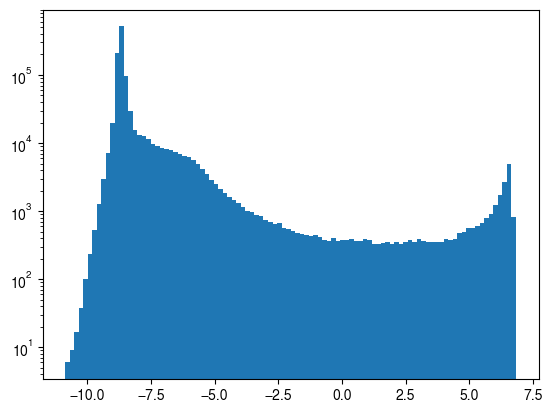

In [10]:
fig, ax = plt.subplots()
ax.hist(event.output, bins = 100)
ax.set_yscale("log")
plt.show()

In [12]:
def get_dfs(event):
    edge_mask = torch.rand(event.edge_index.shape[1]) >= 0.
    edges = event.edge_index[:, (event.scores > 0.99) & edge_mask].numpy()
    graph = coo_matrix((np.ones(edges.shape[1]), edges), shape = (edges.max() + 1, edges.max() + 1)).tocsr()
    _, track_id = connected_components(graph, directed=False)

    hid = np.arange(edges.max() + 1)
    tight_track_df = pd.DataFrame({
        "hid": hid,
        "tight_id": track_id,
        "r": event.r[hid],
        "x": event.r[hid] * torch.cos(event.phi[hid]),
        "y": event.r[hid] * torch.sin(event.phi[hid]),
    })

    tight_track_df = tight_track_df.merge(tight_track_df.groupby("tight_id").size().rename("nhits"), on="tight_id")
    tight_track_df = tight_track_df[tight_track_df["nhits"] >= 9]
    
    hid = torch.cat([event.hit_id[event.track_edges[0]], event.hit_id[event.track_edges[1]]])
    edge_scores = torch.zeros(event.truth_map.shape)
    edge_scores[event.truth_map >= 0] = event.scores[event.truth_map[event.truth_map >= 0]]
    truth_df = pd.DataFrame({
        "hid": hid,
        "pid": event.particle_id.repeat(2),
        "edge_scores": edge_scores.repeat(2),
        "nhits": event.nhits.repeat(2),
        "pt": event.pt.repeat(2),
        "x": event.r[hid]* torch.cos(event.phi[hid]),
        "y": event.r[hid]* torch.sin(event.phi[hid]),
        "r": event.r[hid]
    })

    truth_df = truth_df[(truth_df["nhits"] >= 4) & (truth_df["pt"] > 1000)]
    truth_df = truth_df.drop_duplicates(["hid", "pid"], ignore_index = True)
    return tight_track_df, truth_df

In [13]:
def chi_square(df):
    r2 = df["r"] ** 2
    u = df["x"] / r2
    v = df["y"] / r2
    _, residuals, _, _, _ = np.polyfit(u, v, 2, full = True)
    return pd.Series(residuals / (len(df) - 2), index=["chi_square"])
tight_track_df, truth_df = get_dfs(event)

In [14]:
data = truth_df.groupby("pid").agg({"edge_scores": "min"}).reset_index()
data = data.merge(truth_df.groupby("pid").apply(chi_square).reset_index(), on="pid")
data = data.merge(truth_df.groupby("pid").agg({"nhits": "mean"}).reset_index(), on="pid")
data["log_chi_square"] = np.log(data["chi_square"])

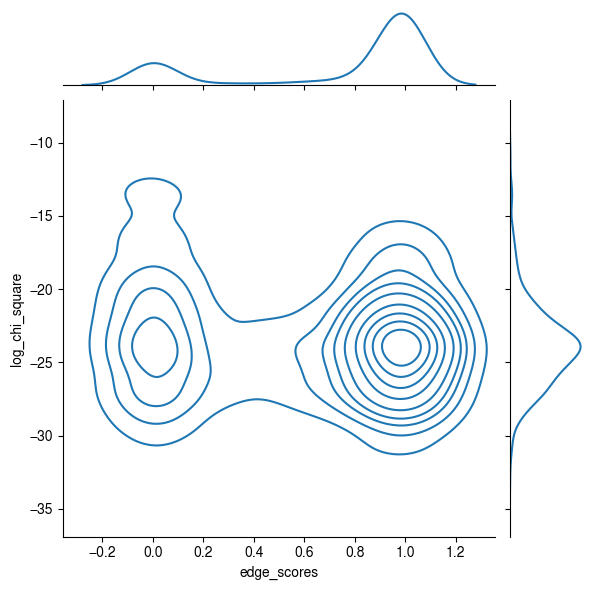

In [15]:
sns.jointplot(data, x="edge_scores", y="log_chi_square", kind="kde")

In [16]:
%%time
(tight_track_df.groupby("tight_id").apply(chi_square) > 1e-9).mean()

CPU times: user 431 ms, sys: 19.3 ms, total: 450 ms
Wall time: 437 ms


chi_square    0.094836
dtype: float64

In [17]:
%%time
(truth_df.groupby("pid").apply(chi_square) > 1e-9).mean()

CPU times: user 605 ms, sys: 34.2 ms, total: 639 ms
Wall time: 615 ms


chi_square    0.117057
dtype: float64

## Idealized HGNN Tracking

In [3]:
def idealized_hgnn_tracking(event, loose_cut, tight_cut, min_hits, random_drop = 0.):
    edge_mask = torch.rand(event.edge_index.shape[1]) >= random_drop
    edges = event.edge_index[:, (event.scores > tight_cut) & edge_mask].numpy()
    graph = coo_matrix((np.ones(edges.shape[1]), edges), shape = (edges.max() + 1, edges.max() + 1)).tocsr()
    _, track_id = connected_components(graph, directed=False)

    tight_track_df = pd.DataFrame({
        "hid": np.arange(edges.max() + 1),
        "tight_id": track_id,
    })

    tight_track_df = tight_track_df.merge(tight_track_df.groupby("tight_id").size().rename("nhits"), on="tight_id")
    tight_track_df = tight_track_df[tight_track_df["nhits"] >= min_hits]

    edges = event.edge_index[:, (event.scores > loose_cut) & edge_mask].numpy()
    graph = coo_matrix((np.ones(edges.shape[1]), edges), shape = (edges.max() + 1, edges.max() + 1)).tocsr()
    _, track_id = connected_components(graph, directed=False)

    loose_track_df = pd.DataFrame({
        "hid": np.arange(edges.max() + 1),
        "loose_id": track_id
    })
    loose_track_df["is_isolated"] = ~ loose_track_df.duplicated(subset=["loose_id"], keep=False)

    isolated_hits = loose_track_df[loose_track_df["is_isolated"]]["hid"].drop_duplicates()
    passed_hits = tight_track_df["hid"].drop_duplicates()

    truth_df = pd.DataFrame({
        "hid": torch.cat([event.hit_id[event.track_edges[0]], event.hit_id[event.track_edges[1]]]),
        "pid": event.particle_id.repeat(2),
    })

    truth_df = truth_df.drop_duplicates(["hid", "pid"], ignore_index = True)
    truth_df = truth_df[~truth_df["hid"].isin(isolated_hits) & ~truth_df["hid"].isin(passed_hits)]
    tracks = np.stack([truth_df.hid, truth_df.pid + tight_track_df.tight_id.max() + 1])
    tracks = np.concatenate([tracks, np.stack([tight_track_df.hid, tight_track_df.tight_id])], axis = 1)
    return torch.as_tensor(tracks), isolated_hits.size / event["hit_id"].shape[0]

In [ ]:
bins = np.linspace(1000, 20000, 20)
all_stats = {}
hgnn_stats = {}
cut_stats = {}

def evaluate_track(event, track):
    matching_df, truth_df = evaluate_tracking(
        event, 
        track,
        min_hits = 5,
        selection = {
            "pt": ("range", [1000, None]),
            "eta": ("range", [-4, 4]),
            "primary": ("isin", [1]), 
            "nhits": ("range", [7, None]),
            "pdgId": ("notin", [11, -11]),
        },
        target_selection = {
            "pt": ("range", [1000, None]),
            "nhits": ("range", [3, None]),
        },
        matching_fraction = 0.5,
        style="two-way"
    )
    stats = get_statistics(matching_df, truth_df, "pt", bins)
    return stats

for path in tqdm(paths):
    event = torch.load(path)
    tracks = torch.stack([torch.arange(event.labels.shape[0])[event.labels >= 0], event.labels[event.labels >= 0]])
    
    stats = evaluate_track(event, tracks)
    if all_stats:
        for name in all_stats:
            all_stats[name].append(stats[name])
    else:
        for name in stats:
            all_stats[name] = [stats[name]]
            
    hgnn_tracks, hgnn_frac = idealized_hgnn_tracking(event, 5e-3, 0.99, 9, 0.)
    stats = evaluate_track(event, hgnn_tracks)
    stats["size_reduction"] = hgnn_frac
    if hgnn_stats:
        for name in hgnn_stats:
            hgnn_stats[name].append(stats[name])
    else:
        for name in stats:
            hgnn_stats[name] = [stats[name]]
    
    damaged_hgnn_tracks, damaged_hgnn_frac = idealized_hgnn_tracking(event, 5e-3, 0.99, 9, 0.1)
    stats = evaluate_track(event, damaged_hgnn_tracks)
    stats["size_reduction"] = damaged_hgnn_frac
    if cut_stats:
        for name in cut_stats:
            cut_stats[name].append(stats[name])
    else:
        for name in stats:
            cut_stats[name] = [stats[name]]

  4%|▍         | 42/1000 [00:42<15:10,  1.05it/s]

In [ ]:
def plot_stats(stat, key, ax, legend):
    df = pd.concat(stat[key]).reset_index().groupby("bin_id").agg(["mean", "std"])
    xerr = np.stack([bins[df[key]["mean"].index.astype(int)], bins[df[key]["mean"].index.astype(int)+1]])
    xloc = xerr.mean(0)
    xerr = xerr - xloc
    xerr[0] = - xerr[0]
    yloc = df[key]["mean"]
    if "size_reduction" in stat:
        legend = legend + f", reduced {sum(stat['size_reduction'])/10:.1f}% hits"
    ax.errorbar(xloc, yloc, yerr=None, xerr=xerr, ls="", label = legend)

In [ ]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
plot_stats(all_stats, "tracking_efficiency", ax, "walkthrough")
plot_stats(hgnn_stats, "tracking_efficiency", ax, "idealized hgnn")
plot_stats(cut_stats, "tracking_efficiency", ax, "idealized hgnn w/ 0.1 random drop")
ax.legend()
ax.set_ylabel("Tracking efficiency")
ax.set_xlabel(r"$p_T$ (MeV)")
ax.set_ylim([0.8, 1.02])
ax.grid(which="both")
plt.show()
fig.savefig("/global/homes/r/ryanliu/commonframework/notebooks/figs/track.pdf")

In [ ]:
fig, (ax) = plt.subplots(ncols=1, nrows=1)
plot_stats(all_stats, "signal_efficiency", ax, "walkthrough")
plot_stats(hgnn_stats, "signal_efficiency", ax, "idealized hgnn")
plot_stats(cut_stats, "signal_efficiency", ax, "idealized hgnn w/ 0.1 random drop")
ax.legend()
ax.set_ylabel("Signal efficiency")
ax.set_xlabel(r"$p_T$ (MeV)")
ax.set_ylim([0.9, 1.02])
ax.grid(which="both")
plt.show()
fig.savefig("/global/homes/r/ryanliu/commonframework/notebooks/figs/signal.pdf")

## Scipy Tracking

In [35]:
%%time
data = PartialData(event, edge_cut=0.001, loose_cut=0.01, tight_cut=1.0, target_selection={
    "pt": ("range", [500, None]),
    "nhits": ("range", [3, None]),
})
tight_edges = data.partial_event.edge_index[:, (torch.sigmoid(data.partial_event.output) > 0.9)].numpy()
graph = coo_matrix((np.ones(tight_edges.shape[1]), tight_edges), shape = (data.partial_event.hit_id.shape[0], data.partial_event.hit_id.shape[0])).tocsr()
_, track_id = connected_components(graph, directed=False)
tracks = torch.stack(
    [
        torch.arange(track_id.shape[0]),
        torch.as_tensor(track_id)
    ], dim = 0
)
matching_df, truth_df = evaluate_tracking(
    event, 
    data.get_tracks(tracks),
    min_hits = 3,
    signal_selection = {
        "pt": ("range", [1000, None]),
        "radius": ("range", [None, None]),
        "eta": ("range", [-4, 4]),
        "primary": ("isin", [1]), 
        "nhits": ("range", [7, None]),
        "pdgId": ("notin", [11, -11]),
    },
    target_selection = {
        "pt": ("range", [1000, None]),
        "nhits": ("range", [3, None]),
    },
    matching_fraction = 0.5,
    style="ATLAS"
)
get_statistics(matching_df, truth_df)

CPU times: user 11.1 s, sys: 1.02 s, total: 12.1 s
Wall time: 239 ms


{'reconstructed_particles': 1319,
 'total_particles': 1547,
 'reconstructed_signal': 1129,
 'total_signal': 1136,
 'num_duplicated_tracks': 70,
 'num_matched_particles': 1319,
 'duplicate_rate': 0.053070507960576156,
 'num_tracks': 1392,
 'num_reconstructed_particles': 1319,
 'fake_rate': 0.05244252873563282}

In [36]:
matching_df, truth_df = evaluate_tracking(
    event, 
    data.get_tracks(tracks),
    min_hits = 3,
    signal_selection = {
        "pt": ("range", [1000, None]),
        "radius": ("range", [None, None]),
        "eta": ("range", [-4, 4]),
        "primary": ("isin", [1]), 
        "nhits": ("range", [7, None]),
        "pdgId": ("notin", [11, -11]),
    },
    target_selection = {
        "pt": ("range", [1000, None]),
        "nhits": ("range", [3, None]),
    },
    matching_fraction = 0.5,
    style="two-way"
)
get_statistics(matching_df, truth_df)

{'reconstructed_particles': 1288,
 'total_particles': 1547,
 'reconstructed_signal': 1118,
 'total_signal': 1136,
 'num_duplicated_tracks': 0,
 'num_matched_particles': 1288,
 'duplicate_rate': 0.0,
 'num_tracks': 1392,
 'num_reconstructed_particles': 1288,
 'fake_rate': 0.07471264367816155}

## Bipartite Matching

In [60]:
truth_bgraph, truth_info = build_truth_bgraph(
    event, 
    signal_selection = {
        "pt": ("range", [1000, None]),
        "eta": ("range", [-4, 4]),
        "primary": ("isin", [1]), 
        "nhits": ("range", [7, None]),
        "pdgId": ("notin", [11, -11]),
    },
    # target_selection = {
    #     "pt": ("range", [1000, None]),
    #     "nhits": ("range", [3, None]),
    # },
)


In [61]:
%%time
pred_bgraph, pred_info = build_pred_bgraph(event, tracks, 0)
graph = (truth_bgraph.T @ pred_bgraph).tocoo()
graph.eliminate_zeros()
graph.data = np.square(graph.data) / truth_info["nhits"][graph.row].numpy() / pred_info["track_size"][graph.col].numpy()
num_particles, num_tracks = graph.shape
graph = coo_matrix(
    (np.concatenate([graph.data, 1e-12 * np.ones(num_particles)]),
     (
         np.concatenate([graph.row, np.arange(num_particles)]),
         np.concatenate([graph.col, np.arange(num_particles) + num_tracks]) # include virtual tracks for each particle
     )
    ),
    shape = (num_particles, num_particles + num_tracks)
)
row, col = min_weight_full_bipartite_matching(graph, maximize = True)
row, col = row[col <= num_tracks], col[col <= num_tracks]
track_to_particle = - torch.ones(num_tracks, dtype = torch.long)
track_to_particle[col] = torch.as_tensor(row)

CPU times: user 705 ms, sys: 21.9 ms, total: 727 ms
Wall time: 526 ms


In [62]:
%%time
skip = (truth_bgraph @ truth_bgraph.T).tocoo()
skip.data.size

CPU times: user 41.8 ms, sys: 13 ms, total: 54.8 ms
Wall time: 55.3 ms


1664729

In [22]:
%%time
input_pred_graph = torch.stack([
    tracks[0],
    track_to_particle[pred_info["track_id"]]
], dim = 0)

y = torch.zeros(input_pred_graph.shape[1], dtype=torch.bool)
y[input_pred_graph[1] >= 0] = 0
input_truth_graph = truth_bgraph.tocoo()
input_truth_graph = torch.stack([
    torch.as_tensor(input_truth_graph.row), 
    torch.as_tensor(input_truth_graph.col)
], dim = 0)

y[input_pred_graph[1] >= 0] = graph_intersection(
    input_pred_graph[:, input_pred_graph[1] >= 0],
    input_truth_graph,
    return_pred_to_truth=False,
    return_truth_to_pred=False,
    unique_pred=True,
    unique_truth=True,
)

weights = torch.ones(input_pred_graph.shape[1], dtype = torch.float)
weights[truth_info["is_signal"][input_pred_graph[1]] & (input_pred_graph[1] >= 0)] *= 2
weights[~y] /= (weights[~y].sum() * 2)
weights[y] /= (weights[y].sum() * 2)

CPU times: user 101 ms, sys: 12.5 ms, total: 113 ms
Wall time: 56.3 ms


In [23]:
y.shape

torch.Size([27978])

In [24]:
tracks.shape

torch.Size([2, 27978])

In [27]:
y.sum() / y.shape[0]

tensor(0.5357)

In [26]:
weights.sum()

tensor(1.0000)

## Partial Data Test

In [15]:
%%time
data = PartialData(event, edge_cut=0.001, loose_cut=0.01, tight_cut=1.0, target_selection={
    "pt": ("range", [500, None]),
    "nhits": ("range", [3, None]),
})
data.to("cuda").partial_event

CPU times: user 181 ms, sys: 4.53 ms, total: 186 ms
Wall time: 93.1 ms


Data(x=[50041], edge_index=[2, 49181], y=[49181], hit_id=[50041], z=[50041], r=[50041], phi=[50041], eta=[50041], dz=[49181], dr=[49181], dphi=[49181], deta=[49181], output=[49181], track_edges=[2, 35817], eta_particle=[35817], radius=[35817], nhits=[35817], particle_id=[35817], pt=[35817], pdgId=[35817], primary=[35817])

In [16]:
%%time
partial_event = data.partial_event
tracks = torch.stack(
    [
        data.partial_event.track_edges.reshape(-1),
        data.partial_event.particle_id.repeat(2)
    ], dim = 0
).unique(dim = 1)
y, weights, relavent_mask, truth_bgraph = data.fetch_truth(
    tracks,
    torch.ones(tracks.shape[1])
)

CPU times: user 291 ms, sys: 13.2 ms, total: 304 ms
Wall time: 153 ms


In [17]:
y.sum() / data.truth_info["nhits"].sum()

tensor(0.8070, device='cuda:0')

In [7]:
y.all()

tensor(True, device='cuda:0')

In [20]:
relavent_mask.sum()

tensor(13690, device='cuda:0')

In [21]:
y.shape

torch.Size([13690])

In [ ]:
all_tracks = data.get_tracks(tracks).cpu()
some_tracks = data.get_tracks(tracks[:, y]).cpu()
all_tracks.shape, some_tracks.shape

In [ ]:
%%time
matching_df, truth_df = evaluate_tracking(
    event, 
    some_tracks,
    min_hits = 5,
    signal_selection = {
        "pt": ("range", [1000, None]),
        "radius": ("range", [None, None]),
        "eta": ("range", [-4, 4]),
        "primary": ("isin", [1]), 
        "nhits": ("range", [7, None]),
        "pdgId": ("notin", [11, -11]),
    },
    target_selection = {},
    matching_fraction = 0.5,
    style="two-way"
)
get_statistics(matching_df, truth_df)

## Preconstruct BGraph

In [76]:
%%time
data = PartialData(event, edge_cut=0.001, loose_cut=0.005, tight_cut=0.99, random_drop = 0.1)

CPU times: user 176 ms, sys: 12.4 ms, total: 189 ms
Wall time: 94.7 ms


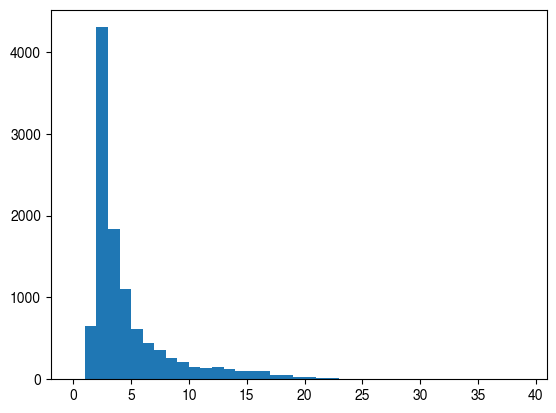

In [77]:
plt.hist(np.unique(track_id, return_counts = True)[1], bins = np.arange(40))
plt.show()

In [92]:
tight_edges = data.partial_event.edge_index[:, (torch.sigmoid(data.partial_event.output) > data.loose_cut)].numpy()
graph = coo_matrix((np.ones(tight_edges.shape[1]), tight_edges), shape = (data.partial_event.hit_id.shape[0], data.partial_event.hit_id.shape[0])).tocsr()
_, track_id = connected_components(graph, directed=False)
tracks = torch.stack(
    [
        torch.arange(track_id.shape[0]),
        torch.as_tensor(track_id)
    ], dim = 0
)
track_graph = torch.as_tensor(track_id)[data.partial_event.edge_index]
num_tracks = track_id.max() + 1
track_graph = coo_matrix(
    (
        np.ones(track_graph.shape[1]),
        track_graph.numpy()
    ),
    shape = (num_tracks, num_tracks)
).tocsr()
track_graph = ((track_graph + track_graph.T) > 0).astype(float)
bgraph, pred_info = build_pred_bgraph(data.partial_event, tracks, 0)

In [89]:
bgraph = bgraph @ track_graph

In [93]:
bgraph = bgraph.tocoo()
partial_event = data.partial_event
tracks = torch.stack([torch.as_tensor(bgraph.row), torch.as_tensor(bgraph.col)], dim = 0).long()
y, weights = data.fetch_truth(
    tracks,
    torch.ones(tracks.shape[1])
)
some_tracks = data.get_tracks(tracks[:, y]).cpu()

In [94]:
%%time
matching_df, truth_df = evaluate_tracking(
    event, 
    some_tracks,
    min_hits = 5,
    signal_selection = {
        "pt": ("range", [1000, None]),
        "radius": ("range", [None, None]),
        "eta": ("range", [-4, 4]),
        "primary": ("isin", [1]), 
        "nhits": ("range", [7, None]),
        "pdgId": ("notin", [11, -11]),
    },
    target_selection = {},
    matching_fraction = 0.5,
    style="two-way"
)
get_statistics(matching_df, truth_df)

CPU times: user 194 ms, sys: 7.22 ms, total: 202 ms
Wall time: 101 ms


{'reconstructed_particles': 2032,
 'total_particles': 14878,
 'reconstructed_signal': 927,
 'total_signal': 1136,
 'num_duplicated_tracks': 0,
 'num_matched_particles': 2032,
 'duplicate_rate': 0.0,
 'num_tracks': 2682,
 'num_reconstructed_particles': 2032,
 'fake_rate': 0.24235645041014164}

## Hierarchical GNN

In [15]:
with open("/global/homes/r/ryanliu/commonframework/examples/Example_hgnn/track_building_train.yaml") as f:
    hparams = yaml.safe_load(f)
    
model_config = hparams["model_config"]
from gnn4itk_cf.stages.track_building.models.gnn_modules.hgnn_models import Pooling, InteractionGNNBlock, HierarchicalGNNBlock

In [16]:
data = PartialData(event, edge_cut=1e-3, loose_cut=2e-3, tight_cut=0.99).to("cuda")
graph = torch.cat([data.partial_event.edge_index, data.partial_event.edge_index.flip(0)], dim=1)
node_attr = torch.stack([data.partial_event.z, data.partial_event.r, data.partial_event.phi], dim = 1).float()

In [17]:
interaction_layer = InteractionGNNBlock(
    d_model = model_config["d_model"],
    n_node_features = len(hparams["node_features"]),
    n_node_layers = model_config["n_node_layers"],
    n_edge_layers = model_config["n_edge_layers"],
    n_iterations = model_config["n_interaction_iterations"],
    hidden_activation = model_config["hidden_activation"],
    output_activation = model_config["output_activation"],
    dropout = model_config["dropout"],
).cuda()
pooling_layer = Pooling(
    d_model=model_config["d_model"],
    emb_size=model_config["emb_size"],
    n_output_layers=model_config["n_output_layers"],
    hidden_activation = model_config["hidden_activation"],
    output_activation = model_config["output_activation"],
    dropout = model_config["dropout"],
    momentum = model_config["cut_momentum"],
    bsparsity = model_config["bsparsity"],
    ssparsity = model_config["ssparsity"],
    resolution = model_config["resolution"],
    min_size = model_config["min_size"], 
).cuda()
hgnn_layer = HierarchicalGNNBlock(
    d_model = model_config["d_model"],
    emb_size =  model_config["emb_size"],
    n_node_layers =  model_config["n_node_layers"],
    n_edge_layers =  model_config["n_edge_layers"],
    n_output_layers = model_config["n_output_layers"],
    n_iterations =  model_config["n_hierarchical_iterations"],
    hidden_activation =  model_config["hidden_activation"],
    output_activation =  model_config["output_activation"],
    dropout =  model_config["dropout"],
).cuda()

In [18]:
nodes, edges = interaction_layer(node_attr, graph)
emb, semb, bgraph, bweights, sgraph, sweights, emb_logits = pooling_layer(nodes, graph)
logits = hgnn_layer(nodes, edges, semb, graph, bgraph, bweights, sgraph, sweights)